In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기
data = pd.read_csv('OBS_ASOS_DD_20210104225316.csv', encoding = 'cp949')  # 2020-01-01~2010-01-01
data1 = pd.read_csv('OBS_ASOS_DD_20210104225407.csv', encoding = 'cp949') # 2010-01-02~2020-01-02
data2 = pd.read_csv('OBS_ASOS_DD_20210104225442.csv', encoding = 'cp949') # 2020-01-03~2021-01-03

data = pd.concat([data,data1,data2],axis=0).reset_index().drop('index',axis=1)

In [3]:
# 데이터 전처리  
# 강수, 적설량과 관련된 변수는 0으로 결측 채우기  
rain_col = [i for i in data.columns if '강수' in i]
snow_col = [i for i in data.columns if '적설' in i]

data[rain_col+snow_col] = data[rain_col+snow_col].fillna(0)

data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']] = data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']].fillna(0)

# 사용하지 않는 컬럼 버리기
data = data.drop(['기사','강수 계속시간(hr)','10분 최다 강수량(mm)'],axis=1)

time_col=[i for i in data.columns if '시각' in i]
data = data.drop(time_col, axis=1)

data = data.drop(['지점','지점명'], axis=1)

# 시간 순서로 학습시키기 위해 시간 정렬
data = data.sort_values('일시').interpolate(method='linear')

# 보간 후 결측치 없음을 확인
print('결측치 개수 =',data.isna().sum().sum())

결측치 개수 = 0


In [4]:
# 라벨값 설정
data['Y'] = data['평균기온(°C)'].shift(-2)
data = data.dropna()

# train, valid, test dataset 분리
train = data[data['일시']<'2013-01-01']
valid = data[data['일시']>='2013-01-01']
valid = valid[valid['일시']<'2017-01-01']
test = data[data['일시']>='2017-01-01']
print(' train set:',len(train),'개\n',
      'valid set:',len(valid),'개\n',
      'test set',len(test),'개')

# X와 Y분리
trainX,trainY = train.drop(['일시','Y'],axis=1), train['Y']
validX,validY = valid.drop(['일시','Y'],axis=1), valid['Y']
testX,testY = test.drop(['일시','Y'],axis=1), test['Y']

 train set: 4749 개
 valid set: 1461 개
 test set 1462 개


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


Bidirectional을 적용해보자  

In [7]:
inputs_1 = tf.keras.Input(shape=(1,44))
rnn = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(100, return_sequences=True))(inputs_1)
rnn = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(100, return_sequences=False))(rnn)
output = tf.keras.layers.Dense(1)(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='mse', optimizer=optimizer)
RNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 44)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 200)            29000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               60200     
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 89,401
Trainable params: 89,401
Non-trainable params: 0
_________________________________________________________________


Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4710/4749 [============================>.] - ETA: 0s - loss: 100.2398
Epoch 00001: val_loss improved from inf to 80.58367, saving model to checkpoint.keras
4749/4749 [==============================] - 2s 500us/sample - loss: 99.9271 - val_loss: 80.5837
Epoch 2/200
4710/4749 [============================>.] - ETA: 0s - loss: 42.2138
Epoch 00002: val_loss improved from 80.58367 to 35.11587, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 101us/sample - loss: 42.1251 - val_loss: 35.1159
Epoch 3/200
4470/4749 [===========================>..] - ETA: 0s - loss: 27.2604
Epoch 00003: val_loss improved from 35.11587 to 28.76548, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 105us/sample - loss: 26.9746 - val_loss: 28.7655
Epoch 4/200
4650/4749 [============================>.] - ETA: 0s - loss: 25.0778
Epoch 00004: val_loss improved from 28.76548 to 22.74411, saving mod

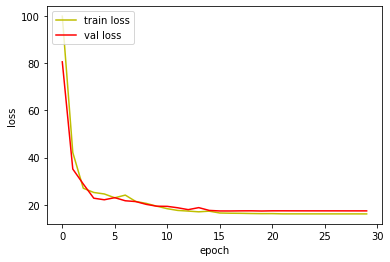

In [8]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(trainX.values.reshape(-1,1,44),trainY, validation_data=(validX.values.reshape(-1,1,44), validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_RNN =  3.3513405501546973


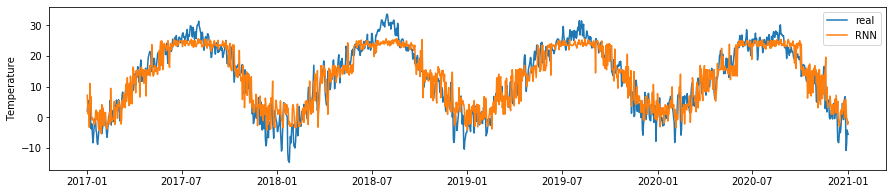

In [9]:
time = pd.to_datetime(test['일시'])

pred_RNN = RNN.predict(testX.values.reshape(-1,1,44)).reshape(-1,)


plt.figure(figsize = (15,3))
plt.plot(time,testY.reset_index()['Y'])
plt.plot(time,pred_RNN)

plt.ylabel('Temperature')
plt.legend(['real','RNN'])

print('MAE')
print('MAE_RNN = ',(((testY-pred_RNN.reshape(-1,))**2)**0.5).mean())

DNN으로 예측한 결과로 MAE를 계산했을 때, 2.x 정도 나왔다.  
RNN 결과는 3.x로 DNN보다 MAE도 낮고 그래프 상으로 보았을 때도 잘 예측하였다고 할 수 없다.  
여름과 겨울, 온도가 높아지고 낮아질 때 예측 정확도가 낮다.  
RNN을 잘못 쓰고 있는건 아닐까?

참고 글  
https://frhyme.github.io/machine-learning/simple_rnn/  
https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/  
https://dreamgonfly.github.io/blog/understanding-rnn/  
https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-27%EC%9D%BC%EC%B0%A8-rnn-many-to-one-9c785962960d

### RNN(Recurrent Neural Network)  
RNN은 시퀀스 데이터를 모델링 하기 위해 등장했다.  
위의 3개의 글을 보면 공통적으로 등장하는 그림이 있다.  
입력되는 데이터의 시퀀스 길이와 반환하는 시퀀스의 길이에 따라 RNN의 구조가 달라진다.  
이 구조를 모두 구현해보려한다.  
1) one to one  
2) one to many  
3) many to one  
4) many to many  
5) 또 다른 many to many  

1) one to one은 위에 구현되어 있는 RNN구조이다.  
먼저 그림과 같은 구조로 구현하기 위해 rnn층을 하나만 사용하여 구현하겠다.    

#### 1) one to one

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 44)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               9500      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________
Train on 4749 samples, validate on 1461 samples
Epoch 1/200
3870/4749 [=======================>......] - ETA: 0s - loss: 168.1796
Epoch 00001: val_loss improved from inf to 115.73467, saving model to checkpoint.keras
4749/4749 [==============================] - 1s 254us/sample - loss: 156.6324 - val_loss: 115.7347
Epoch 2/200
4590/4749 [===========================>..] - ETA: 0s - loss

Epoch 29/200
4350/4749 [==========================>...] - ETA: 0s - loss: 13.7061
Epoch 00029: val_loss improved from 14.11399 to 14.09613, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 57us/sample - loss: 13.4515 - val_loss: 14.0961
Epoch 30/200
4290/4749 [==========================>...] - ETA: 0s - loss: 13.4787
Epoch 00030: val_loss improved from 14.09613 to 14.09467, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 58us/sample - loss: 13.4376 - val_loss: 14.0947
Epoch 31/200
3960/4749 [========================>.....] - ETA: 0s - loss: 13.3655
Epoch 00031: val_loss improved from 14.09467 to 14.05533, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 79us/sample - loss: 13.4240 - val_loss: 14.0553
Epoch 32/200
4020/4749 [========================>.....] - ETA: 0s - loss: 13.4116
Epoch 00032: val_loss improved from 14.05533 to 14.03188, saving model to checkpoint.keras
4749/4749 [=========

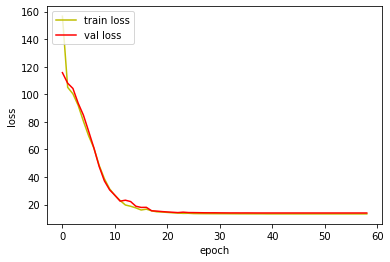

In [11]:
inputs_1 = tf.keras.Input(shape=(1,44))
rnn = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=False))(inputs_1)
output = tf.keras.layers.Dense(1)(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='mse', optimizer=optimizer)
RNN.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(trainX.values.reshape(-1,1,44),trainY, validation_data=(validX.values.reshape(-1,1,44), validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_RNN =  2.8898954855321453


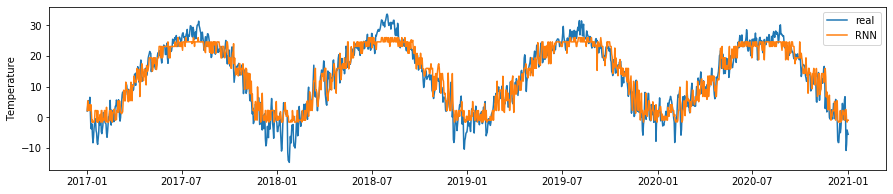

In [12]:
time = pd.to_datetime(test['일시'])

pred_RNN = RNN.predict(testX.values.reshape(-1,1,44)).reshape(-1,)


plt.figure(figsize = (15,3))
plt.plot(time,testY.reset_index()['Y'])
plt.plot(time,pred_RNN)

plt.ylabel('Temperature')
plt.legend(['real','RNN'])

print('MAE')
print('MAE_RNN = ',(((testY-pred_RNN.reshape(-1,))**2)**0.5).mean())

#### 2) one to many  
한장의 사진을 여러 단어로 이루어진 문장으로 학습하고 싶을 때 활용된다.  
입력과 출력 시퀀스 길이를 다르게 받는 모델을 설계하기 위해선 데이터 형태도 변형시켜야 한다  
모델 설계를 위해선 입력과 출력을 정의하여야 한다.  
one to many 형태의 rnn을 구현하기 위해 입력은 t시점의 기상 관측 데이터, 출력은 t+2,t+3,t+4 시점의 평균기온으로 정의한다.  

In [13]:
Y_len = 3
Y = [data['Y'].iloc[i:i+3].values for i in range(len(data)-2)]
data = data.drop(['Y'],axis=1).iloc[:-2]

In [14]:
# train, valid, test dataset 분리
train = data[data['일시']<'2013-01-01']
valid = data[data['일시']>='2013-01-01']
valid = valid[valid['일시']<'2017-01-01']
test = data[data['일시']>='2017-01-01']
print(' train set:',len(train),'개\n',
      'valid set:',len(valid),'개\n',
      'test set',len(test),'개')

# X와 Y분리
trainX = train.drop(['일시'],axis=1)
validX = valid.drop(['일시'],axis=1)
testX = test.drop(['일시'],axis=1)

trainY = Y[:len(trainX)]
validY = Y[len(trainX):len(trainX)+len(validX)]
testY = Y[-len(testX):]

 train set: 4749 개
 valid set: 1461 개
 test set 1460 개


one to many를 구현하기 위해 repeat vector를 사용하였다  
다른 방법은 없을까?  

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 44)             0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 3, 100)            9500      
_________________________________________________________________
dense_2 (Dense)              (None, 3, 1)              101       
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________
Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4620/4749 [============================>.] - ETA: 0s - loss: 131.9919
Epoch 00001: val_loss improved from inf to 111.16408, saving model to checkpoint.keras
4749/4749 [===========================

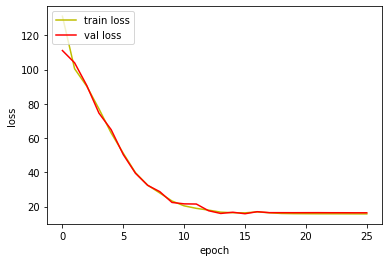

In [15]:
inputs_1 = tf.keras.Input(shape=44)
rnn = tf.keras.layers.RepeatVector(Y_len)(inputs_1)
rnn = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True))(rnn)
output = tf.keras.layers.Dense(1)(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='mse', optimizer=optimizer)
RNN.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(trainX.values,np.array(trainY).reshape(-1,3,1), validation_data=(validX.values, np.array(validY).reshape(-1,3,1)), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_RNN =  2.941133725404331


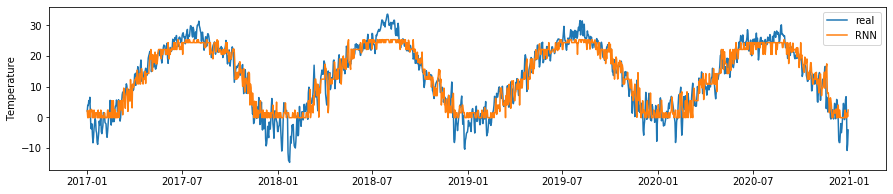

In [16]:
time = pd.to_datetime(test['일시'])
# 예측 시점
n = 0

pred = RNN.predict(testX)


plt.figure(figsize = (15,3))
plt.plot(time,np.array(testY)[:,n])
plt.plot(time,pred[:,n])

plt.ylabel('Temperature')
plt.legend(['real','RNN'])

print('MAE')
print('MAE_RNN = ',(((np.array(testY)[:,n]-pred[:,n].reshape(-1,))**2)**0.5).mean())

In [17]:
print('이틀 뒤를 예측한 결과, MAE = ',(((np.array(testY)[:,n]-pred[:,n].reshape(-1,))**2)**0.5).mean())
print('사흘 뒤를 예측한 결과, MAE = ',(((np.array(testY)[:,n+1]-pred[:,n].reshape(-1,))**2)**0.5).mean())
print('나흘 뒤를 예측한 결과, MAE = ',(((np.array(testY)[:,n+2]-pred[:,n].reshape(-1,))**2)**0.5).mean())

이틀 뒤를 예측한 결과, MAE =  2.941133725404331
사흘 뒤를 예측한 결과, MAE =  3.103732203043079
나흘 뒤를 예측한 결과, MAE =  3.152927190581821


먼 미래를 예측할수록 오차가 커지는 경향을 보인다.  

#### 3) many to one

In [18]:
len(train),len(valid),len(test)

(4749, 1461, 1460)

In [28]:
Xstep = 3
# train, valid, test dataset 분리
data['Y'] = data['평균기온(°C)'].shift(-2)
data = data.dropna()
X = data.drop(['일시','Y'],axis=1).values
Y = data['Y'].iloc[2:]

x = [X[i:i+3] for i in range(len(X)-2)]

trainX = x[:4749]
validX = x[4749:4749+1460]
testX = x[4749+1460:]

trainY = Y.iloc[:4749]
validY = Y.iloc[4749:4749+1460]
testY = Y.iloc[4749+1460:]

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3, 44)]           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100)               9500      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________
Train on 4749 samples, validate on 1460 samples
Epoch 1/200
4320/4749 [==========================>...] - ETA: 0s - loss: 148.4222
Epoch 00001: val_loss improved from inf to 114.23359, saving model to checkpoint.keras
4749/4749 [==============================] - 1s 278us/sample - loss: 145.1419 - val_loss: 114.2336
Epoch 2/200
4380/4749 [==========================>...] - ETA: 0s - loss

4230/4749 [=========================>....] - ETA: 0s - loss: 16.9054
Epoch 00029: val_loss did not improve from 17.73577

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
4749/4749 [==============================] - 0s 84us/sample - loss: 16.7019 - val_loss: 17.8462
Epoch 30/200
4680/4749 [============================>.] - ETA: 0s - loss: 16.7612
Epoch 00030: val_loss did not improve from 17.73577

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
4749/4749 [==============================] - 0s 80us/sample - loss: 16.6830 - val_loss: 17.8510
Epoch 31/200
4230/4749 [=========================>....] - ETA: 0s - loss: 16.5114
Epoch 00031: val_loss did not improve from 17.73577

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
4749/4749 [==============================] - 1s 131us/sample - loss: 16.6314 - val_loss: 17.8522
Epoch 32/200
4530/4749 [===========================>..] - ETA: 0s - loss: 16

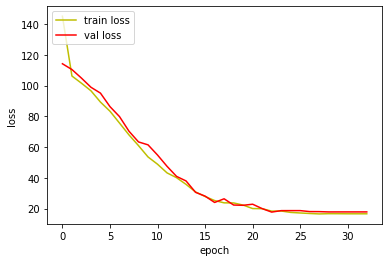

In [29]:
inputs_1 = tf.keras.Input(shape=(3,44))
rnn = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=False))(inputs_1)
output = tf.keras.layers.Dense(1)(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='mse', optimizer=optimizer)
RNN.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(np.array(trainX).reshape(-1,3,44),trainY.values, 
               validation_data=(np.array(validX).reshape(-1,3,44), validY.values), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_RNN =  3.304193302335482


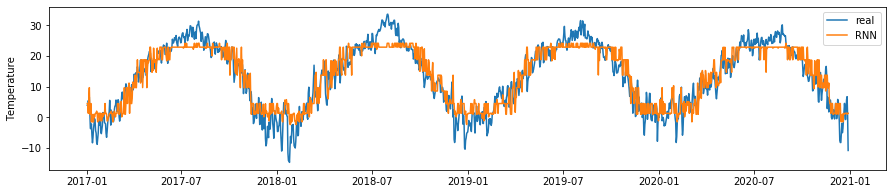

In [31]:
time = pd.to_datetime(test['일시']).iloc[1:-2]
# 예측 시점
n = 0

pred = RNN.predict(np.array(testX).reshape(-1,3,44))


plt.figure(figsize = (15,3))
plt.plot(time,np.array(testY))
plt.plot(time,pred)

plt.ylabel('Temperature')
plt.legend(['real','RNN'])

print('MAE')
print('MAE_RNN = ',(((np.array(testY)-pred.reshape(-1,))**2)**0.5).mean())

#### 4) many to many

In [32]:
Xstep = 3
Ystep = 3

Y = [data['Y'].iloc[i:i+3].values for i in range(len(data)-2)]
X = data.drop(['일시','Y'],axis=1).values
x = [X[i:i+3] for i in range(len(X)-2)]

# train, valid, test dataset 분리
trainX = x[:4749]
validX = x[4749:4749+1460]
testX = x[4749+1460:]

trainY = Y[:4749]
validY = Y[4749:4749+1460]
testY = Y[4749+1460:]

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3, 44)]           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 3, 100)            9500      
_________________________________________________________________
dense_6 (Dense)              (None, 3, 1)              101       
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________
Train on 4749 samples, validate on 1460 samples
Epoch 1/200
4050/4749 [========================>.....] - ETA: 0s - loss: 138.0832
Epoch 00001: val_loss improved from inf to 112.05587, saving model to checkpoint.keras
4749/4749 [==============================] - 1s 299us/sample - loss: 133.1363 - val_loss: 112.0559
Epoch 2/200
4680/4749 [============================>.] - ETA: 0s - loss

Epoch 29/200
4290/4749 [==========================>...] - ETA: 0s - loss: 11.1225
Epoch 00029: val_loss did not improve from 11.55186
4749/4749 [==============================] - 0s 83us/sample - loss: 11.0988 - val_loss: 11.5601
Epoch 30/200
4260/4749 [=========================>....] - ETA: 0s - loss: 11.1684
Epoch 00030: val_loss did not improve from 11.55186
4749/4749 [==============================] - 0s 83us/sample - loss: 11.0899 - val_loss: 11.5770
Epoch 31/200
4350/4749 [==========================>...] - ETA: 0s - loss: 11.1410
Epoch 00031: val_loss did not improve from 11.55186
4749/4749 [==============================] - 0s 81us/sample - loss: 11.0872 - val_loss: 11.5708
Epoch 32/200
4350/4749 [==========================>...] - ETA: 0s - loss: 11.0814
Epoch 00032: val_loss did not improve from 11.55186
4749/4749 [==============================] - 0s 82us/sample - loss: 11.0798 - val_loss: 11.5746
Epoch 33/200
4230/4749 [=========================>....] - ETA: 0s - loss: 11.095

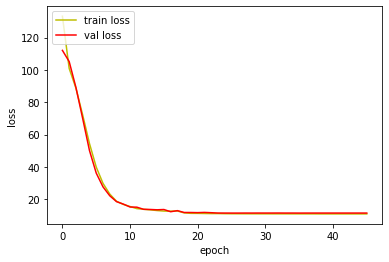

In [33]:
inputs_1 = tf.keras.Input(shape=(3,44))
rnn = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(50, return_sequences=True))(inputs_1)
output = tf.keras.layers.Dense(1)(rnn)

RNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RNN.compile(loss='mse', optimizer=optimizer)
RNN.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RNN.fit(np.array(trainX).reshape(-1,3,44),np.array(trainY).reshape(-1,3,1), 
               validation_data=(np.array(validX).reshape(-1,3,44), np.array(validY).reshape(-1,3,1)), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_RNN =  2.6441094049563865


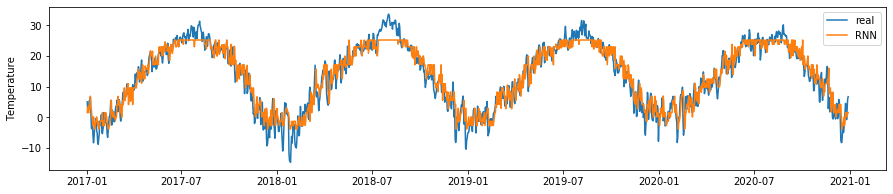

In [35]:
time = pd.to_datetime(test['일시']).iloc[1:-2]
# 예측 시점
n = 0

pred = RNN.predict(np.array(testX).reshape(-1,3,44))


plt.figure(figsize = (15,3))
plt.plot(time,np.array(testY)[:,n])
plt.plot(time,pred[:,n].reshape(-1,))

plt.ylabel('Temperature')
plt.legend(['real','RNN'])

print('MAE')
print('MAE_RNN = ',(((np.array(testY)[:,n]-pred[:,n].reshape(-1,))**2)**0.5).mean())

In [36]:
print('MAE_RNN = ',(((np.array(testY)[:,0]-pred[:,n].reshape(-1,))**2)**0.5).mean())
print('MAE_RNN = ',(((np.array(testY)[:,1]-pred[:,n].reshape(-1,))**2)**0.5).mean())
print('MAE_RNN = ',(((np.array(testY)[:,2]-pred[:,n].reshape(-1,))**2)**0.5).mean())

MAE_RNN =  2.6441094049563865
MAE_RNN =  2.9193573294086
MAE_RNN =  3.0629733306562237


Bidirection을 적용했을때 MAE가 더 감소했음을 확인할 수 있다.  

tf.keras.layers.SimpleRNN  레이어 설명을 보면 다음과 같다.  